# 1. Préambule

Avant toute chose, **assurez-vous d'avoir suivi le cours RL 101 sur les bandits manchots**.

## 1.1. Récompense, action et état

Dans le cours RL 101, nous avons défini les notions fondamentales d'action et de récompense. Nous avons parlé de la notion d'état sans toutefois nous en servir.

Dans les problèmes de bandits manchots, nous n'avions pas d'état à propremement parler : étant donnée l'action choisie, la récompense était la même.

Il arrive nombre de situations où ce n'est pas le cas. Imaginez par exemple un véhicule qui doit transporter de gauche à droite une barre à la verticale. Il peut accélérer à tout moment vers la gauche ou vers la droite. **La décision optimale (d'accélération à droite ou à gauche) dépend évidemment de la situation dans laquelle il se trouve (l'état).**

![title](img/pole_balancing_task.png)

Pour en apprendre plus sur la modélisation de ces systèmes dynamiques, renseignez-vous sur les **processus de Markov**.

## 1.2. La programmation dynamique

Initiée par Richard Bellman au début des années 1950, **la programmation dynamique (*Dynamic Programming* ou DP) reste l'un des piliers de l'optimisation des systèmes dynamiques**. On part d'un système dont l'état à l'instant $t$ est noté $S_t \in \mathcal{S}$. A chaque instant, on obtient une récompense $R_t$ (qui dépend de l'état), puis on choisit une action $A_t \in \mathcal{A}$ qui nous emmène en $S_{t+1} = f_t\left(S_t, A_t, \omega_t\right)$, avec $\omega_t$ un processus stochastique indépendant de l'état ou de l'action.

L'idée derrière la programmation dynamique est la suivante : **si je connais la valeur (à long-terme) de n'importe quel état $s \in \mathcal{S}$, alors il est beaucoup plus facile de choisir mon action à chaque instant**, car il suffit de choisir celle qui va maximiser la somme de ma récompense instantanée et de la valeur de l'état dans lequel je vais atterrir.

Pour calculer cette valeur à long-terme que l'on appelle fonction-valeur ou valeur de Bellman :
* On adopte la notation générique **$\pi$ pour parler d'une stratégie**, c'est-à-dire d'une fonction qui va associer à tout état $s \in S$ du système une action $a$ ;
* On note alors **$V_\pi$ la fonction qui a chaque état associe sa valeur à long-terme (la fonction-valeur)**, c'est-à-dire la somme des récompenses que l'on peut gagner à partir de cet état en suivant la stratégie $\pi$.

La fonction-valeur associée à la stratégie $\pi$ est ainsi définie simplement par la somme des récompenses que l'on obtiendra en utilisant la stratgéie $\pi$ :
$$
V_\pi(s) = \mathbb{E}\left[ \sum_{t=0}^{+\infty} \gamma^t \times R_{t+1} | S_0=s, A_t=\pi(S_t), S_{t+1} = f_t\left(S_t, A_t, \omega_t\right) \right]
$$

**L'équation de la programmation dynamique indique que, si $\pi_*$ est la stratégie optimale, alors :**

$$
V_{\pi^*}(s) = \max_a \mathbb{E}\left[ R_{t+1} + V_{\pi^*}(S_{t+1}) | S_t=s, A_t=a\right],
$$

avec :
* $R_t$ la récompense obtenue à l'instant $t$ (par abus de notation, car la récompense dépend en réalité de l'état $s$),
* $S_{t+1} = f_t(S_t, A_t, \omega_t)$

# 2. Applications

La plupart des (sinon toutes les) méthodes d'apprentissage par renforcement sur des systèmes dynamiques se rapportent à l'équation de la programmation dynamique.

## 2.1. Policy Iteration

Ici, l'idée est de partir d'une stratégie $\pi_0$, de calculer la fonction-valeur associée $V_{\pi_0}$, puis d'améliorer cette stratégie à l'aide de l'équation de la programmation dynamique. On obtient une nouvelle stratégie que l'on note $\pi_1$, et ainsi de suite...

$$
\pi_0 \rightarrow V_{\pi_0} \rightarrow \pi_1 \rightarrow \dots \rightarrow \pi_* \rightarrow V_*
$$

### Jack's car rental

Jack possède deux magasins de locations de voiture, assez éloignés l'un de l'autre. Chaque jour, les clients arrivent pour louer une voiture et, s'il en a une disponible, il la loue 10€. Les voitures redeviennent disponibles seulement le lendemain matin de leur retour. Pour s'assurer qu'il a bien assez de voitures dans sa location, il peut les amener d'un magasin à l'autre au coût de 2€ (en une nuit seulement).

On supposera que le nombre de voitures demandées (et ramenées) chaque jour suit une loi de Poisson d'espérance $\lambda$. Autrement dit, la probabilité de voir $n$ demandes de location sur une journée est $\frac{\lambda^n}{n!} e^{-\lambda}$. On suppose que $\lambda$ vaut $3$ et $4$ pour les locations, et $3$ et $2$ pour les retours. Pour simplifier, on suppose que chaque location ne peut contenir plus de $20$ véhicules et qu'on ne peut bouger plus de 5 voitures en une nuite. Enfin, on adopte un taux d'escompte (*discount rate*) à chaque instant $\gamma=0.9$.

**Calculez la fonction-valeur associée à la stratégie qui consiste à ne jamais bouger de voitures (en moyennenant sur 100 tirages).** Partons de 10 voitures de chaque côté au démarrage.

In [2]:
import numpy as np

In [41]:
T = 100
nb_samples = 100
gamma = 0.9

val = 0

# initial value of stocks
s1 = s2 = 10

# Computed expected Bellman value
for i in range(nb_samples):
    
    # We compute it over a fixed horizon T
    for t in range(T):
        # Beginning of day t: people come and rent cars (if available)
        rents1 = min(s1, np.random.poisson(3))
        rents2 = min(s2, np.random.poisson(4))

        # Jack gets paid for it (discounted over time)
        val += (gamma**t) * 10 * (rents1 + rents2)

        # End of day: people get cars back (sometimes)
        s1 = max(s1 - rents1 + np.random.poisson(3), 0.)
        s2 = max(s2 - rents2 + np.random.poisson(2), 0.)

print(val / nb_samples)

502.8917187612995


Calculons maintenant pour tous les états de départ possibles.

In [14]:
# In order to loop over two lists
from itertools import product

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [36]:
nb_samples = 100
gamma = 0.9
T = 100

# Bellman function (zero by default)
V = np.zeros(shape=(21, 21))

# Loop over all possible starting states
for s1_0, s2_0 in product(range(21), range(21)):
    
    # Computed expected Bellman value
    for i in range(nb_samples):
        s1, s2 = s1_0, s2_0
        
        # We compute it over a fixed horizon T
        for t in range(T):
            # Beginning of day t: people come and rent cars (if available)
            rents1 = min(s1, np.random.poisson(3))
            rents2 = min(s2, np.random.poisson(4))
            
            # Jack gets paid for it (discounted over time)
            V[s1_0, s2_0] += (gamma**t) * 10 * (rents1 + rents2)
            
            # End of day: people get cars back (sometimes)
            s1 = max(s1 - rents1 + np.random.poisson(3), 0.)
            s2 = max(s2 - rents2 + np.random.poisson(2), 0.)

# Divide to get an expectation
V /= nb_samples

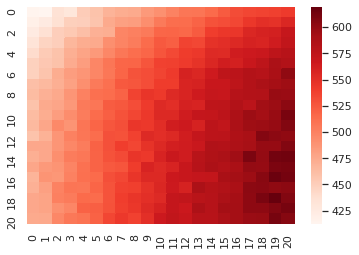

In [37]:
sns.heatmap(V, cmap="Reds")

In [38]:
V[10, 10]

554.8295338142825

**Suivez la stratégie qui consiste à maximiser la somme de la récompense et de $V$.** Stockez cette stratégie dans un `np.ndarray` noté `P`.

In [43]:
# Strategy
P = np.ndarray(shape=(21, 21))

# Loop over all possible states
for s1, s2 in product(range(21), range(21)):
    val_best_action = -1
    # Loop over all possible actions:
    for a in range(-5, 6):
        val = 0.
    
        # Jump over unfeasible states
        if (s1 + a < 0) or (s2 - a < 0):
            continue

        # Sample the expectation of reward + gamma * V
        for i in range(nb_samples):
            # Beginning of day t: people come and rent cars (if available)
            rents1 = min(s1 + a, np.random.poisson(3))
            rents2 = min(s2 - a, np.random.poisson(4))
            
            # End of day: people get cars back (sometimes)
            # We get future state
            s1p = min(max(s1 + a - rents1 + np.random.poisson(3), 0), 20)
            s2p = min(max(s2 - a - rents2 + np.random.poisson(2), 0), 20)
            
            # Jack gets paid for rents and we add future estimated value
            val += 10 * (rents1 + rents2) - 2 * np.abs(a) + gamma * V[s1p, s2p]
        
        # Divide by nb_samples to get an expectation
        val /= nb_samples
        
        # Select best action
        if val > val_best_action:
            P[s1, s2] = a
            val_best_action = val

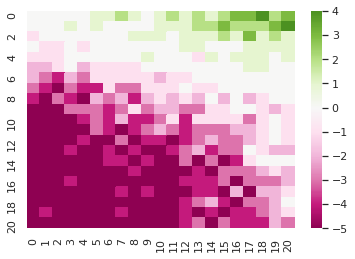

In [44]:
sns.heatmap(P, center=0., cmap="PiYG")

**Now that you have a new policy, compute its value function.**

## 2.2. Value Iteration

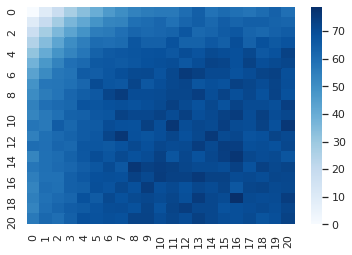

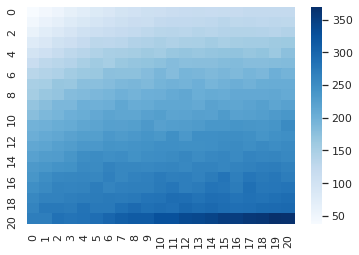

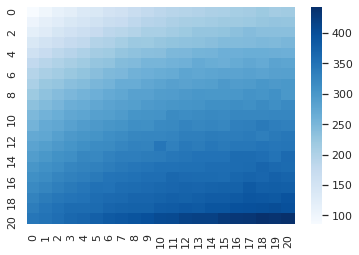

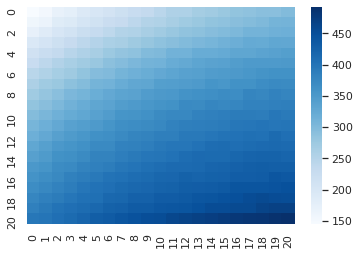

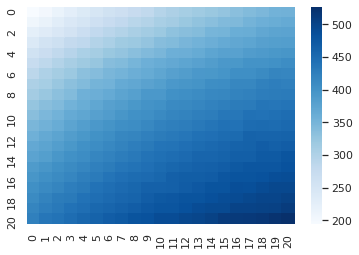

In [46]:
nb_samples = 100
gamma = 0.9
T = 100

# Bellman function (zero by default)
V = np.zeros(shape=(21, 21))
Vp = np.zeros(shape=(21, 21))

for k in range(5):
    # Loop over all possible states
    for s1, s2 in product(range(21), range(21)):
        val_best_action = -1
        # Loop over all possible actions
        for a in range(-5, 6):
            val = 0.

            # Jump over unfeasible states
            if (s1 + a < 0) or (s2 - a < 0):
                continue

            # Loop over a large random sample of days to be sure of best action
            for i in range(nb_samples):
                # Beginning of day t: people come and rent cars (if available)
                rents1 = min(s1 + a, np.random.poisson(3))
                rents2 = min(s2 - a, np.random.poisson(4))

                # End of day: people get cars back (sometimes)
                # We get future state
                s1p = min(max(s1 + a - rents1 + np.random.poisson(3), 0), 20)
                s2p = min(max(s2 - a - rents2 + np.random.poisson(2), 0), 20)

                # Jack gets paid for rents and we add future estimated value
                val += 10 * (rents1 + rents2) - 2 * np.abs(a) + gamma * V[s1p, s2p]

            # Divide by nb_samples to get an expectation
            val /= nb_samples

            # Select best action value
            if val > val_best_action:
                val_best_action = val
        
        # Update V (Vp temporarily)
        Vp[s1, s2] = val_best_action

    # Update V
    V = Vp
    sns.heatmap(V, cmap="Blues")
    plt.show()

# 3. Temporal-Difference Learning

**Le TD Learning est le coeur de ce qui fait l'efficacité de l'apprentissage par renforcement : un mélange de programmation dynamique et de Monte-Carlo.**

Comme on a pu le constater, le calcul exhaustif fait par la programmation dynamique (tant sur l'espace des états que des aléas) rend son calcul relativement lent. **Le temps de calcul de la programmation dynamique augmente en fait de manière exponentielle avec la dimension de l'état. C'est ce que Bellman a nommé la malédiction de la dimension (*curse of dimensionality*).**

Avec le TD-Learning, ces frontières sont *en partie* repoussées.

## 3.1. TD(0)

Avec cet algorithme, la formule de mise à jour de la fonction de Bellman $V(s)$ sur un état $s \in \mathcal{S}$ devient :

$$
V_{k+1}(s) = V_k(s) + \alpha \left[R + \gamma V_k(s') - V_k(s)\right],
$$

avec $s'=f(s, a, \omega)$ et $a$ l'action optimale étant donnée la fonction valeur $V_k$, soit :

$$
\arg\max_a \left[R + \gamma V_k(s')\right].
$$

**Mettez en oeuvre cet algorithme afin de trouver la stratégie optimale en partant d'un état initial de 5 voitures dans chaque magasin.** Vers quelles valeurs l'état converge-t-il ?

In [7]:
###

# 4. Q-Learning

## 4.1. Action-value function $Q$ instead of value function $V$

**L'un des plus importants bonds en avant de l'apprentissage par renforcement est dû à Chris Watkins, en 1989, avec l'algorithme du $Q$-learning.**

La première clé de simplification des algorithmes tels que $Q$-learning ou encore SARSA est le fait de **stocker non plus la valeur de n'importe quel état $s \in \mathcal{S}$ mais la valeur de n'importe quel couple état-action $s, a \in \mathcal{S} \times \mathcal{A}$.**

$$
Q(s, a) = R + \mathbb{E}\left[V(s')\right],
$$
avec $s'=f(s, a, \omega)$.

## 4.2. $Q$-learning update rule

La formule générale de mise à jour du $Q$-learning est la suivante :

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1} + \gamma \max_a Q\left(S_{t+1}, a\right) - Q(S_t, A_t)\right].
$$

Mettons-la en oeuvre sur un exemple.

### The cliff-walking task

![title](img/cliff_walking_task.png)

On part d'en bas à gauche et on veut arriver le plus rapidement possible est bas à droite, sans tomber de la falaise (en bas). Chaque pas (haut, bas, gauche, droite) nous coûte -1.

In [48]:
class Environment(object):
    from typing import Tuple
    
    def __init__(self, width: int, height: int):
        self.width, self.height = width, height
    
    def reward(self, x: int, y: int):
        """Returns the reward associated with a given
        position (x, y)
        """
        # Unallowed positions
        if (x < 0) or (y < 0) or (x >= self.width) or (y >= self.height):
            raise ValueError(f"x={x}, y={y}")
        
        if (y == 0) and (x == self.width-1):
            return 0 # final position
        elif (y == 0) and (x > 0):
            return -100
        else:
            return -1
    
    def finished(self, x: int, y: int):
        """Returns True if game is finished at this (x, y) position
        """
        return (y == 0) and (x > 0)
    
    def move(self, x: int, y: int, a: Tuple[int, int]):
        """Returns the next state, given state and action
        """
        return min(max(x + a[0], 0), self.width-1), min(max(y + a[1], 0), self.height-1)

env = Environment(width=12, height=4)

In [49]:
# Intializing state-action value function Q(s, a)
# Possible actions are up, down, left, right
Q = np.zeros(shape=(12, 4, 4))

# Mapping of actions
actions = [
    (0, 1), # up
    (0, -1), # down
    (-1, 0), # left
    (1, 0), # right
]

# Parameter
eps = 0.1
alpha = 0.1

# Number of episodes (or experiments)
nb_episodes = 1000

# For plotting
list_of_rewards = []

# Loop over episodes
for n in range(nb_episodes):
    # initialize state
    x = y = 0
    
    # for plotting
    rewards = []
    
    # Loop over time steps (until a final state is attained)
    while not env.finished(x, y):
        # Select action (epsilon-greedy Q-learning policy)
        if np.random.uniform() > eps:
            a_idx = np.argmax(Q[x, y, :])
        else:
            a_idx = np.random.randint(0, 4)
        # Map action index to action
        a = actions[a_idx]
        
        # Move and observe reward and next state
        x_next, y_next = env.move(x, y, a)
        r = env.reward(x_next, y_next)
        
        # for plotting
        rewards.append(r)
        
        # Update Q
        Q[x, y, a_idx] += alpha * (r + Q[x_next, y_next, :].max() - Q[x, y, a_idx])
        
        # Update state
        x, y = x_next, y_next
    
    # for plotting
    list_of_rewards.append(rewards)

Affichons la fonction $V$ obtenue, qui n'est autre que la max en $a$ de la fonction $Q$.

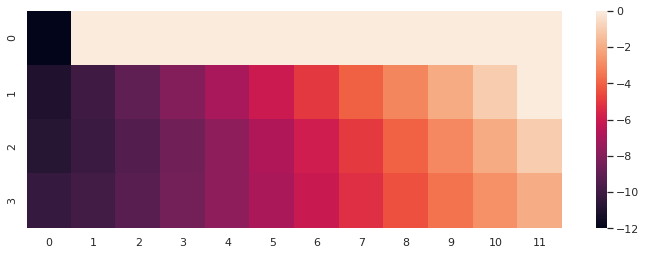

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.heatmap(Q.max(axis=2).transpose(), ax=ax)

On observe bien qu'elle représente la valeur de chaque prochain état, si on suit la stratégie optimale ! Elle est cependant mois précise dans les zones moins visitées, comme `x=11` et `y=0`.

Simulons la stratégie optimale obtenue.

In [54]:
x = y = 0

actions[Q[x, y, :].argmax()]

(0, 1)

L'action optimale est de se déplacer vers le haut. Puis..

In [55]:
x, y = 0, 1

actions[Q[x, y, :].argmax()]

(1, 0)

L'action optimale est de se déplacer vers la droite. allons droit au but !

In [56]:
x = y = 0

while not env.finished(x, y):
    # select best action
    a = actions[Q[x, y, :].argmax()]
    
    x, y = env.move(x, y, a)
    
    print(x, y)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
11 0


**N'est-ce pas magnifique ?**

En combien de temps cela converge ? Regardons les récompenses associées aux épisodes.

In [57]:
import pandas as pd

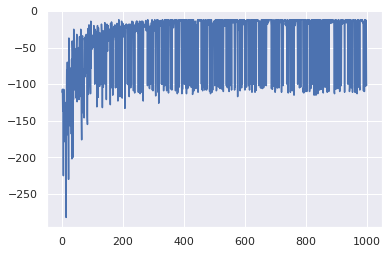

In [63]:
st = pd.Series([sum(rewards) for rewards in list_of_rewards])

plt.plot(st)
#plt.plot(st.rolling(window=10).mean())

Très rapidement ! En quelques centaines d'itératons.

**Pourquoi la récompense sur l'épisode (même lissée) continue-t-elle à osciller ?**

Parce que l'algorithme du $Q$-learning est $\epsilon$-*greedy* : il continuera indéfiniment à sélectionner de temps à autre ses actions au hasard.

Cependant, **c'est un algorithme dit *off-policy*. Bien que sa stratégie de sélection inclut de prendre de temps à autre des actions au hasard, c'est bien la fonction valeur associée à la stratégie optimale qui est calculée !**


# Conclusion provisoire

Il resterait encore beaucoup de choses à voir, et notamment la rétropropagation des traces (les algorithmes TD($\lambda$) et $Q(\lambda)$).